# Data exploration notebook 

In [1]:
import sys
import logging
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import unidecode
sys.path.append('src/')

In [2]:
from dataRetriever import DataRetriever
from utils import set_logger
set_logger(Path('./log/notebook.log'), debug=False)

***

## Registre de casos de COVID-19 realitzats a Catalunya. Segregació per sexe i municipi

In [3]:
infectionData = DataRetriever('jj6z-iyrp')()
infectionData.head()

[2020-12-28 23:28:47,081][socrata.py(63):__init__]-WARNING: Requests made without an app_token will be subject to strict throttling limits.
[2020-12-28 23:28:47,082][dataRetriever.py(56):loadPreviousCsv]-INFO: reading previous data in jj6z-iyrp data from data/jj6z-iyrp/2020-12-28.csv


,comarcacodi,comarcadescripcio,municipicodi,municipidescripcio,sexecodi,sexedescripcio,resultatcoviddescripcio,numcasos,date
0,19.0,Garrotxa,17185.0,Sant Joan Les Fonts,1,Dona,Positiu PCR,1,12-27
1,11.0,Baix Llobregat,8147.0,Olesa de Montserrat,0,Home,Sospitós,2,12-27
2,13.0,Barcelonès,8015.0,Badalona,1,Dona,Sospitós,22,12-27
3,21.0,Maresme,8155.0,Palafolls,0,Home,Sospitós,1,12-27
4,8.0,Baix Camp,43123.0,Reus,1,Dona,Sospitós,5,12-27


In [4]:
deathData = DataRetriever('uqk7-bf9s')()
deathData.head()

[2020-12-28 23:28:47,255][socrata.py(63):__init__]-WARNING: Requests made without an app_token will be subject to strict throttling limits.
[2020-12-28 23:28:47,256][dataRetriever.py(56):loadPreviousCsv]-INFO: reading previous data in uqk7-bf9s data from data/uqk7-bf9s/2020-12-28.csv


,comarcacodi,comarcadescripcio,sexecodi,sexedescripcio,numexitus,date
0,40,Vallès Occidental,1,Dona,1,12-26
1,24,Osona,0,Home,1,12-25
2,31,Ripollès,0,Home,1,12-25
3,7,Bages,0,Home,1,12-25
4,13,Barcelonès,1,Dona,8,12-25


In [5]:
infectionData['numcasos'][infectionData['resultatcoviddescripcio'] == 'Sospitós'] = 0.0
infections = infectionData[['date', 'numcasos']].set_index('date').groupby('date').sum()
deaths = deathData[['date', 'numexitus']].set_index('date').groupby('date').sum()
newdf = infections.join(deaths).fillna(0.0)


In [6]:
infectionDatabyRegion = infectionData[['comarcadescripcio','date', 'numcasos']].dropna()
infectionDatabyRegion = infectionDatabyRegion.pivot_table(index='date', columns='comarcadescripcio', aggfunc=sum).fillna(0.0)
infectionDatabyRegion = infectionDatabyRegion['numcasos']
infectionDatabyRegion.columns = [unidecode.unidecode(columnName.replace(' ','')) + '_pos' for columnName in infectionDatabyRegion.columns]
newdf = newdf.join(infectionDatabyRegion).fillna(0.0)

In [7]:
deathByRegion = deathData[['date', 'numexitus', 'comarcadescripcio']].dropna()
deathByRegion = deathByRegion.pivot_table(index='date', columns='comarcadescripcio', aggfunc=sum).fillna(0.0)
deathByRegion = deathByRegion['numexitus']
deathByRegion.columns = [unidecode.unidecode(columnName.replace(' ','')) + '_death' for columnName in deathByRegion.columns]
newdf = newdf.join(deathByRegion).fillna(0.0)

In [8]:
infectionDatabySex = infectionData[['sexedescripcio','date', 'numcasos']].dropna()
infectionDatabySex = infectionDatabySex.pivot_table(index='date', columns='sexedescripcio', aggfunc=sum).fillna(0.0)
infectionDatabySex = infectionDatabySex['numcasos']
infectionDatabySex.columns = [unidecode.unidecode(columnName.replace(' ','')) + '_pos' for columnName in infectionDatabySex.columns]
newdf = newdf.join(infectionDatabySex).fillna(0.0)

In [9]:
deathDatabySex = deathData[['sexedescripcio','date', 'numexitus']].dropna()
deathDatabySex = deathDatabySex.pivot_table(index='date', columns='sexedescripcio', aggfunc=sum).fillna(0.0)
deathDatabySex = deathDatabySex['numexitus']
deathDatabySex.columns = [unidecode.unidecode(columnName.replace(' ','')) + '_death' for columnName in deathDatabySex.columns]
newdf = newdf.join(deathDatabySex).fillna(0.0)

In [10]:
rodf = infections.copy()
LOOKBACK = 7
POPULATION = 7.566e7
array = rodf.to_numpy().squeeze(-1)
size = len(array)
R0 = np.zeros(size)

for i in range(LOOKBACK, len(array)):
    if array[size-LOOKBACK] == 0:
        R0[i] = 1
    else:
        R0[i] = np.exp((((np.log(POPULATION/((1/(array[i-1]/(array[i-LOOKBACK]*POPULATION)))-1)))/(LOOKBACK-1))))
R0[np.isnan(R0)] = 0.0
R0[np.isinf(R0)] = 0.0
rodf['R0'] = R0
rodf = rodf.drop('numcasos', axis=1)
newdf = newdf.join(rodf).fillna(0.0)

In [11]:
newdf.to_csv('test.tsv', sep='\t')
newdf.head()

,numcasos,numexitus,AltCamp_pos,AltEmporda _pos,AltPenedes_pos,AltUrgell_pos,AltaRibagorca_pos,Anoia_pos,Aran_pos,Bages_pos,...,TerraAlta_death,Urgell_death,Vald'Aran_death,VallesOccidental_death,VallesOriental_death,Dona_pos,Home_pos,Dona_death,Home_death,R0
date,,,,,,,,,,,,,,,,,,,,,
02-26,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
02-27,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,0,0.0,0.0,0.0
02-28,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,0.0,0.0,0.0
02-29,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
03-01,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0


In [12]:
ALL = newdf.to_numpy()
DATES = newdf.index.to_list()

In [23]:
newdf.columns.to_list()[89:91]

['Dona_death', 'Home_death']

In [24]:
ALL_MAX = np.array([np.max(ALL[:, 0])] + [np.max(ALL[:, 1])] + [np.max(ALL[:,2:44])]*42 + [np.max(ALL[:,45:87])]*43 + [np.max(ALL[:,87:89])]*2 + [np.max(ALL[:,89:91])]*2 + [np.max(ALL[:, -1])])[None:]
ALL = ALL / (2*ALL_MAX)

In [26]:
ALL.shape

(306, 92)

In [27]:
X = ALL[:-1]
Y = ALL[:,[0,1,-1]][1:]

In [28]:
X.shape, Y.shape

((305, 92), (305, 3))

In [29]:
from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size=.1)
xTrain.shape, yTrain.shape, xTest.shape, yTest.shape

((274, 92), (274, 3), (31, 92), (31, 3))

In [30]:
from sklearn.neural_network import MLPRegressor
mlpr = MLPRegressor(max_iter=100, batch_size=10, verbose=2, tol=1e-6).fit(xTrain, yTrain)
pred = mlpr.predict(xTest)
print(np.sqrt(np.sum((pred - yTest)**2, axis=0))/pred.shape[0])

Iteration 1, loss = 0.02611400
Iteration 2, loss = 0.00595638
Iteration 3, loss = 0.00257878
Iteration 4, loss = 0.00145346
Iteration 5, loss = 0.00117609
Iteration 6, loss = 0.00110161
Iteration 7, loss = 0.00107916
Iteration 8, loss = 0.00106029
Iteration 9, loss = 0.00102823
Iteration 10, loss = 0.00101432
Iteration 11, loss = 0.00101126
Iteration 12, loss = 0.00099387
Iteration 13, loss = 0.00098337
Iteration 14, loss = 0.00096303
Iteration 15, loss = 0.00095525
Iteration 16, loss = 0.00092320
Iteration 17, loss = 0.00091672
Iteration 18, loss = 0.00090137
Iteration 19, loss = 0.00090072
Iteration 20, loss = 0.00088423
Iteration 21, loss = 0.00087255
Iteration 22, loss = 0.00086798
Iteration 23, loss = 0.00088154
Iteration 24, loss = 0.00085353
Iteration 25, loss = 0.00083391
Iteration 26, loss = 0.00083157
Iteration 27, loss = 0.00083232
Iteration 28, loss = 0.00082320
Iteration 29, loss = 0.00082535
Iteration 30, loss = 0.00082152
Iteration 31, loss = 0.00081600
Iteration 32, los

In [31]:
all_predicted = mlpr.predict(X)
print(np.sqrt(np.sum((all_predicted - Y)**2, axis=0))/Y.shape[0])

[0.00287111 0.00071494 0.00197198]


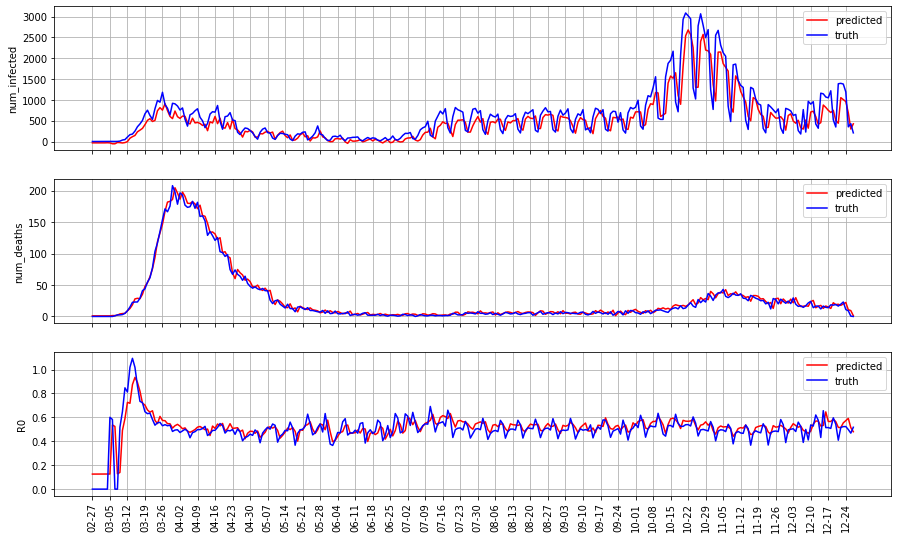

In [32]:
all_predicted *= ALL_MAX[[0,1,-1]]
Y *= ALL_MAX[[0,1,-1]]

f, ax = plt.subplots(3, 1, sharex=True, figsize=(15, 9))

subpred = all_predicted[:, 0]
subtruth = Y[:, 0]
ax[0].plot(subpred, c='r', label='predicted')
ax[0].plot(subtruth, c='b', label='truth')
ax[0].set_ylabel('num_infected')
ax[0].grid('on')
ax[0].legend()

subpred = all_predicted[:, 1]
subtruth = Y[:, 1]
ax[1].plot(subpred, c='r', label='predicted')
ax[1].plot(subtruth, c='b', label='truth')
ax[1].set_ylabel('num_deaths')
ax[1].grid('on')
ax[1].legend()

subpred = all_predicted[:, 2]
subtruth = Y[:, 2]
ax[2].plot(subpred, c='r', label='predicted')
ax[2].plot(subtruth, c='b', label='truth')
ax[2].set_ylabel('R0')
ax[2].grid('on')
ax[2].legend()

plt.xticks(range(0, len(DATES[1:]), 7), DATES[1::7], rotation=90)
plt.show()